In [29]:
import json
import pickle
from itertools import combinations, chain

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import osmnx as ox
import sklearn.cluster as cls
import sklearn.metrics as met
import sklearn.neighbors as nb

import bachelors_thesis.util as util

In [30]:
data_path = "../../data"

In [31]:
## Load road graph
road_graph = util.load_graph(f"{data_path}/road_graph/road_graph_ox_nsl_sim_sc.pickle")
road_graph = ox.project_graph(road_graph, to_crs=util.EPSG_32650)

## Load camera info
cameras_dict: dict
with open(f"{data_path}/road_graph/road_graph_ox_nsl_sim_sc_cameras.pickle", mode="rb") as file:
    cameras_dict = pickle.load(file)

Silhouette Score: 0.4954711369794857
Region records:  [1673377, 1582237, 1637736]


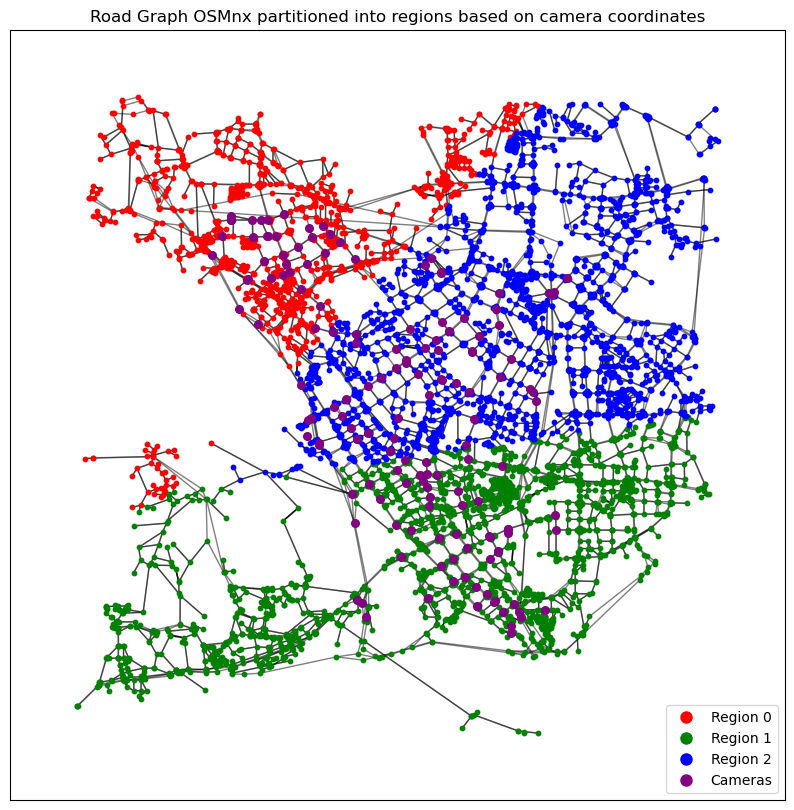

In [32]:
# Parameters
seed = 666
number_of_regions = 3
colors = ["red", "green", "blue", "yellow", "orange", "cyan", "brown", "pink", "purple"]

nodes = [{"node_id": node, "x": road_graph.nodes[node]["x"], "y": road_graph.nodes[node]["y"]} for node in
         road_graph.nodes()]
node_coordinates = np.array([[node["x"], node["y"]] for node in nodes])

cameras = list(cameras_dict.values())
camera_coordinates = np.array([[camera["x"], camera["y"]] for camera in cameras])
camera_nodes = {camera["node_id"] for camera in cameras}

## Clustering
k_means_cameras = cls.KMeans(number_of_regions, random_state=seed)
regions = k_means_cameras.fit_predict(camera_coordinates)
print(f"Silhouette Score: {met.silhouette_score(camera_coordinates, regions, random_state=seed)}")

# Record distribution
region_records = [0 for _ in range(number_of_regions)]
for region, camera in zip(regions, cameras):
    region_records[region] += camera["records"]
print("Region records: ", region_records)

## Matching nodes to cluster centroids
kd_tree = nb.KDTree(k_means_cameras.cluster_centers_)
indices = kd_tree.query(node_coordinates, k=1, return_distance=False)
indices = indices.flatten()

region_nodes = [set() for _ in range(number_of_regions)]
for index, node in zip(indices, nodes):
    region_nodes[index].add(node["node_id"])

## Visualization
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
pos = {node: (road_graph.nodes[node]["x"], road_graph.nodes[node]["y"]) for node in road_graph.nodes()}

nx.draw_networkx_edges(
    road_graph,
    pos,
    arrows=False,
    alpha=0.5,
    ax=ax
)

for index, nodes in enumerate(region_nodes):
    nx.draw_networkx_nodes(
        road_graph,
        pos,
        node_color=colors[index],
        node_size=10,
        nodelist=nodes,
        ax=ax
    )

nx.draw_networkx_nodes(
    road_graph,
    pos,
    node_color=colors[-1],
    node_size=30,
    nodelist=camera_nodes,
    ax=ax
)

ax.set_title("Road Graph OSMnx partitioned into regions based on camera coordinates")

legend = list()
for region in range(number_of_regions):
    legend.append(plt.Line2D([0], [0], marker="o", color="w", markerfacecolor=colors[region], markersize=10,
                             label=f"Region {region}"))
legend.append(plt.Line2D([0], [0], marker="o", color="w", markerfacecolor=colors[-1], markersize=10,
                         label=f"Cameras"))
plt.legend(handles=legend)

plt.show()

In [33]:
def find_auxiliary_regions(G: nx.MultiDiGraph, region_nodes: list[set[int]]):
    auxiliary_regions = list()
    number_of_regions = len(region_nodes)

    for i, j in combinations(range(number_of_regions), 2):
        nodes_i = region_nodes[i]
        nodes_j = region_nodes[j]

        edges_i_to_j = {(u, v) for u in nodes_i for v in nodes_j if G.has_edge(u, v)}
        edges_j_to_i = {(u, v) for u in nodes_j for v in nodes_i if G.has_edge(u, v)}

        if not edges_i_to_j and not edges_j_to_i:
            print(f"No edges for auxiliary region {i}-{j}")
            continue

        nodes = set()
        for u, v in chain(edges_i_to_j, edges_j_to_i):
            nodes.add(u)
            nodes.add(v)

        auxiliary_regions.append({
            "auxiliary": True,
            "region": (i, j),
            "nodes": nodes,
            "edges_i_to_j": edges_i_to_j,
            "edges_j_to_i": edges_j_to_i,
        })

    return auxiliary_regions


def expand_auxiliary_regions(G: nx.MultiDiGraph, auxiliary_regions: list[dict], camera_nodes: set[int],
                             min_number_of_camera_nodes: int, min_cutoff: int = 1, max_cutoff: int = 10) -> list[dict]:
    G = G.to_undirected()
    expanded_auxiliary_regions = list()

    for auxiliary_region in auxiliary_regions:
        i, j = auxiliary_region["region"]
        nodes = auxiliary_region["nodes"]

        selected_cutoff = None
        selected_cutoff_nodes = None
        for cutoff in range(min_cutoff, max_cutoff + 1):
            expanded_nodes = set(nodes)
            for node in nodes:
                expanded_nodes.update(nx.single_source_shortest_path_length(G, node, cutoff=cutoff).keys())

            camera_nodes_in_auxiliary_region = expanded_nodes.intersection(camera_nodes)
            if len(camera_nodes_in_auxiliary_region) >= min_number_of_camera_nodes:
                selected_cutoff = cutoff
                selected_cutoff_nodes = expanded_nodes
                break

        if selected_cutoff is None:
            print(f"No cutoff found that satisfies minimum number of camera nodes for auxiliary region {i}-{j}")
            continue

        expanded_auxiliary_regions.append({
            "auxiliary": auxiliary_region["auxiliary"],
            "region": auxiliary_region["region"],
            "nodes": auxiliary_region["nodes"],
            "expanded_nodes": selected_cutoff_nodes,
            "cutoff": selected_cutoff,
            "edges_i_to_j": auxiliary_region["edges_i_to_j"],
            "edges_j_to_i": auxiliary_region["edges_j_to_i"],
        })

    return expanded_auxiliary_regions


def get_records_for_node(node: int, cameras_dict: dict):
    records = 0
    for camera in cameras_dict.values():
        if camera["node_id"] == node:
            records += camera["records"]
    return records

No cutoff found that satisfies minimum number of camera nodes for auxiliary region 0-1


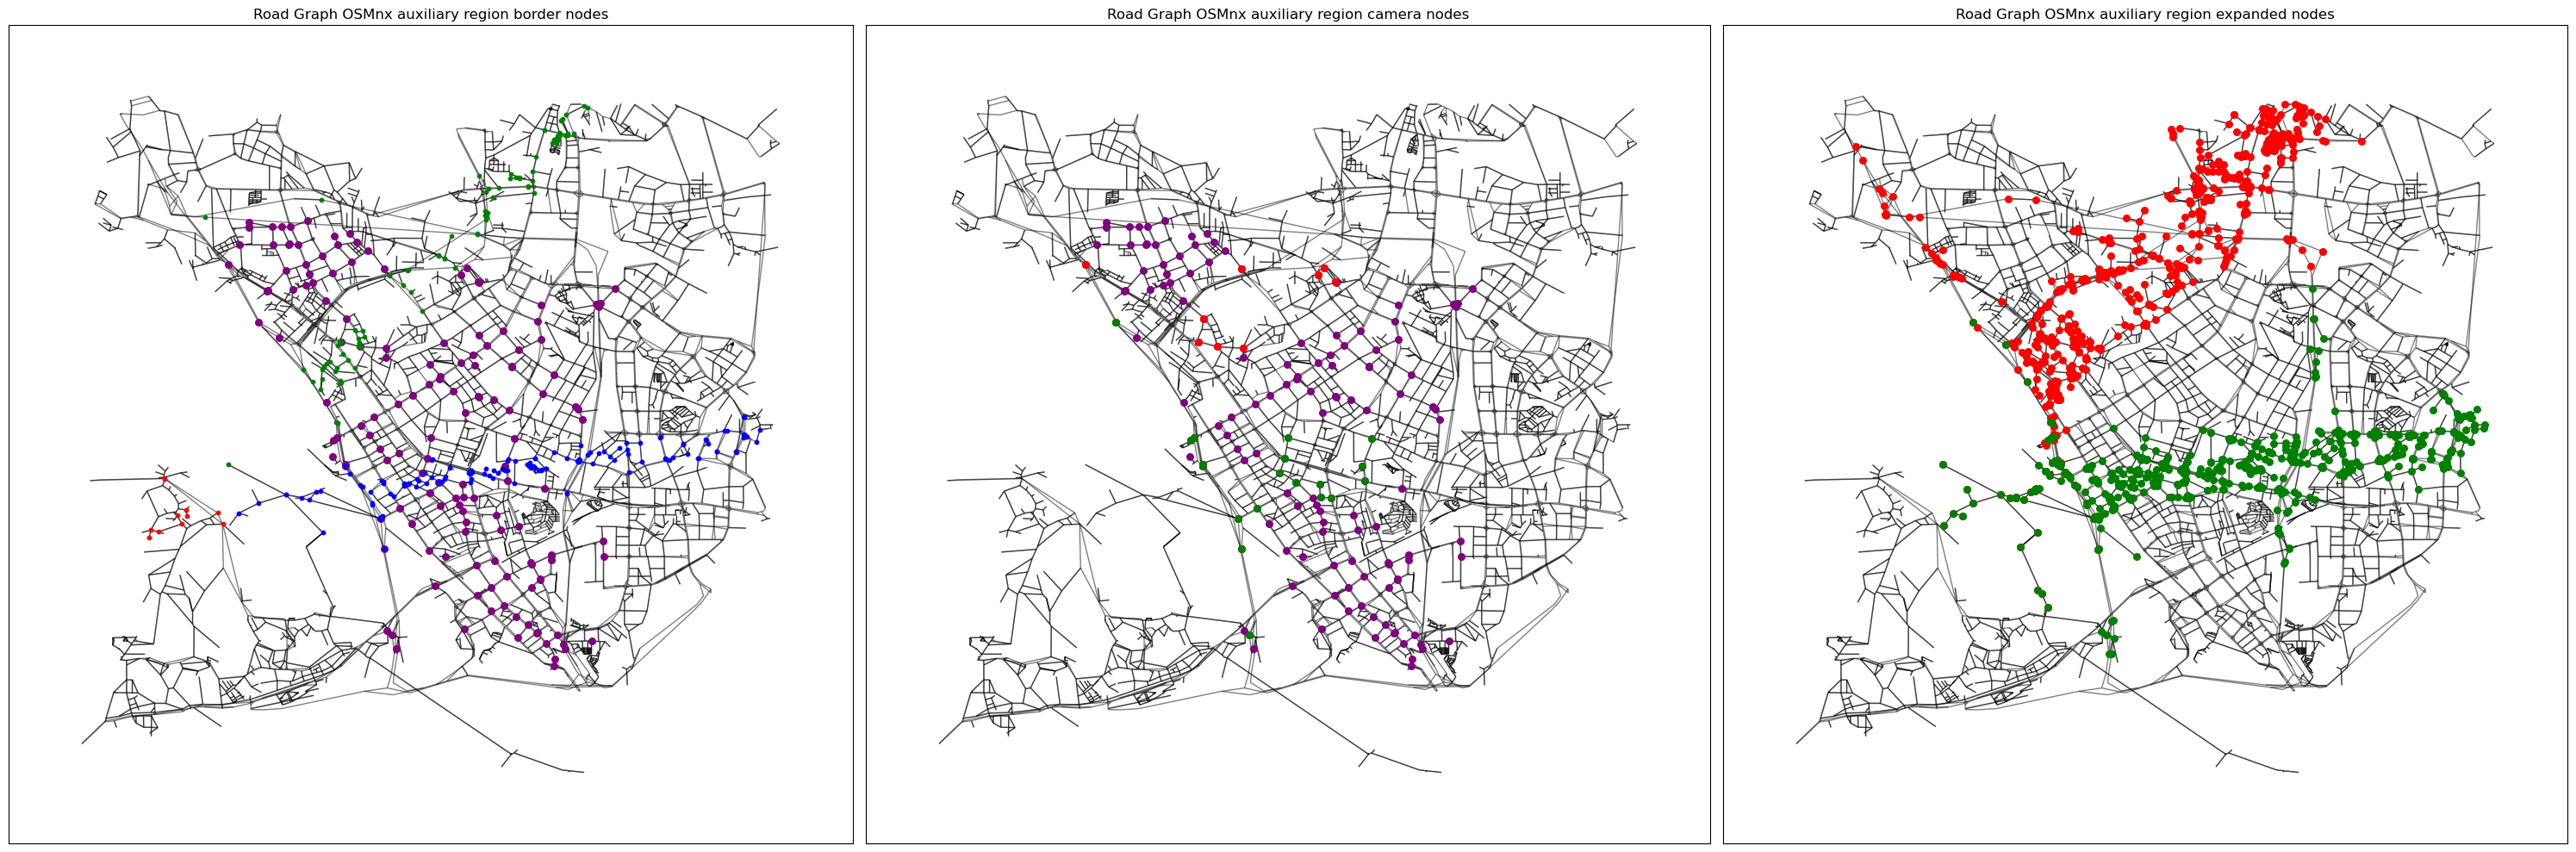

Region 0-2 number of records:  581580
Region 0-2 number of camera nodes:  16
Region 0-2 cutoff:  4
Region 1-2 number of records:  780171
Region 1-2 number of camera nodes:  19
Region 1-2 cutoff:  3


In [34]:
## Find and visualize auxiliary regions
auxiliary_regions = find_auxiliary_regions(road_graph, region_nodes)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 10))

nx.draw_networkx_edges(
    road_graph,
    pos,
    arrows=False,
    alpha=0.5,
    ax=ax1
)

nx.draw_networkx_nodes(
    road_graph,
    pos,
    node_color=colors[-1],
    node_size=30,
    nodelist=camera_nodes,
    ax=ax1
)

for index, auxiliary_region in enumerate(auxiliary_regions):
    nodes = auxiliary_region["nodes"]
    nx.draw_networkx_nodes(
        road_graph,
        pos,
        node_color=colors[index],
        node_size=10,
        nodelist=nodes,
        ax=ax1
    )

ax1.set_title("Road Graph OSMnx auxiliary region border nodes")

auxiliary_regions = expand_auxiliary_regions(road_graph, auxiliary_regions, camera_nodes=camera_nodes,
                                             min_number_of_camera_nodes=15, min_cutoff=1, max_cutoff=10)

nx.draw_networkx_edges(
    road_graph,
    pos,
    arrows=False,
    alpha=0.5,
    ax=ax2
)

nx.draw_networkx_nodes(
    road_graph,
    pos,
    node_color=colors[-1],
    node_size=30,
    nodelist=camera_nodes,
    ax=ax2
)

for index, auxiliary_region in enumerate(auxiliary_regions):
    expanded_nodes = auxiliary_region["expanded_nodes"]
    nx.draw_networkx_nodes(
        road_graph,
        pos,
        node_color=colors[index],
        node_size=30,
        nodelist=expanded_nodes.intersection(camera_nodes),
        ax=ax2
    )

ax2.set_title("Road Graph OSMnx auxiliary region camera nodes")

nx.draw_networkx_edges(
    road_graph,
    pos,
    arrows=False,
    alpha=0.5,
    ax=ax3
)

for index, auxiliary_region in enumerate(auxiliary_regions):
    expanded_nodes = auxiliary_region["expanded_nodes"]
    nx.draw_networkx_nodes(
        road_graph,
        pos,
        node_color=colors[index],
        node_size=30,
        nodelist=expanded_nodes,
        ax=ax3
    )

ax3.set_title("Road Graph OSMnx auxiliary region expanded nodes")

plt.tight_layout()
plt.show()

for auxiliary_region in auxiliary_regions:
    i, j = auxiliary_region["region"]
    expanded_nodes = auxiliary_region["expanded_nodes"]
    cutoff = auxiliary_region["cutoff"]
    camera_nodes_in_auxiliary_region = expanded_nodes.intersection(camera_nodes)

    records = 0
    for camera_node in camera_nodes_in_auxiliary_region:
        records += get_records_for_node(camera_node, cameras_dict)

    print(f"Region {i}-{j} number of records: ", records)
    print(f"Region {i}-{j} number of camera nodes: ", len(camera_nodes_in_auxiliary_region))
    print(f"Region {i}-{j} cutoff: ", cutoff)

In [35]:
# Region: {
#     "auxiliary": False,                           Indicates, whether this is an auxiliary region or not
#     "region": int,                                ID of the region
#     "nodes": list[int],                           IDs of nodes that belong to this region
#     "cameras": list[int],                         IDs of cameras that belong to this region
#     "camera_nodes": list[int],                    IDs of nodes that have cameras (that belong to this region) assigned to them
# }
#
# Auxiliary Region: {
#     "auxiliary": True,                            Indicates, whether this is an auxiliary region or not
#     "region": list[int, int],                     IDs of regions that neighbour this auxiliary region
#     "nodes": list[int],                           IDs of nodes that make up the border between neighbouring regions
#     "expanded_nodes": list[int],                  IDs of nodes that make up this entire auxiliary region
#     "cameras": list[int],                         IDs of cameras that belong to this region
#     "camera_nodes": list[int],                    IDs of nodes that have cameras (that belong to this region) assigned to them
#     "edges_{i}_to_{j}": list[list[int, int]],     Edges that cross the border in the direction i to j
#     "edges_{j}_to_{i}": list[list[int, int]],     Edges that cross the border in the direction j to i
# }

def get_cameras_of_region(region_nodes: set[int], cameras_dict: dict) -> set[int]:
    cameras = set()
    for camera in cameras_dict.values():
        if camera["node_id"] in region_nodes:
            cameras.add(camera["camera_id"])
    return cameras


regions = list()
for index, nodes in enumerate(region_nodes):
    regions.append({
        "auxiliary": False,
        "region": index,
        "nodes": list(nodes),
        "cameras": list(get_cameras_of_region(nodes, cameras_dict)),
        "camera_nodes": list(nodes.intersection(camera_nodes)),
    })

for auxiliary_region in auxiliary_regions:
    regions.append({
        "auxiliary": auxiliary_region["auxiliary"],
        "region": [i for i in auxiliary_region["region"]],
        "nodes": list(auxiliary_region["nodes"]),
        "expanded_nodes": list(auxiliary_region["expanded_nodes"]),
        "cameras": list(get_cameras_of_region(auxiliary_region["expanded_nodes"], cameras_dict)),
        "camera_nodes": list(auxiliary_region["expanded_nodes"].intersection(camera_nodes)),
        "edges_i_to_j": [[u, v] for u, v in auxiliary_region["edges_i_to_j"]],
        "edges_j_to_i": [[u, v] for u, v in auxiliary_region["edges_j_to_i"]],
    })

with open(f"{data_path}/dataset/regions-{number_of_regions}.json", mode="w", encoding="utf-8") as file:
    json.dump(regions, file)